In [1]:
pip install pandasql missingno pydantic-settings pandas_profiling plotly

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install --upgrade pandas-profiling

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as ps
import missingno as msno
from pyspark.sql import SparkSession
# from pandas_profiling import ProfileReport
import plotly.graph_objects as go
# from pydantic_settings import BaseSettings

sns.set()
sns.set_palette('deep')
sns.set_context('notebook')
plt.subplots_adjust(left=0, right=2, top=0.9, bottom=0.1)  # Adjust the values as needed

SPARK = SparkSession.builder.appName('online_retail').master("local").getOrCreate()


def sql(df: pd.DataFrame, query: str, table_name = "online_retail", create_temp_view = False):
    """
    Create a table in SparkSQL.
    Execute a query
    """
    if create_temp_view:
        spark_df = SPARK.createDataFrame(df)
        spark_df.createOrReplaceTempView(table_name)

    return SPARK.sql(query)

def load_data(path = "../datasets/online_retail/Online_Retail_Data_Set.csv"):
    df = pd.read_csv(path, encoding = "ISO-8859-1") 
    return df


def pre_processing(df):

    # Changing dtype to datetime
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed')

    # Remove transactions with negative quantites or negative prices
    df = df[df.Quantity > 0]
    df = df[df.UnitPrice > 0]

    # Replace missing CustomerIDs with 0
    df = df.replace(np.nan, 0)
    
    # Remove duplicates
    df = df[~df.duplicated()]


    # Using Spark to:
    #   1. Aggregate duplicated transactions with different quantites
    #   2. Add a profit column
    #   3. Remove transactions before 2011
    df["InvoiceDate"] = df["InvoiceDate"].astype(str)
    spark_df = SPARK.createDataFrame(df)
    spark_df.createOrReplaceTempView("spark_df")

    query = """
    select 
        aaa.*,
        round(aaa.quantity * aaa.UnitPrice, 2) as Profit
    from
    (
        select 
            InvoiceNo,
            StockCode,
            description,
            sum(quantity) as quantity,
            InvoiceDate,
            UnitPrice,
            CustomerID,
            Country
        from spark_df
        group by
            InvoiceNo,
            StockCode,
            CustomerID,
            description,
            InvoiceDate,
            UnitPrice,
            Country
    ) as aaa
    where
        aaa.InvoiceDate >= '2011-01-01'
    """
    spark_df = SPARK.sql(query)
    df = spark_df.toPandas()
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])


    return df


if __name__ == "__main__":
    #df = load_data()
    #print(df.columns)
    #clean_df = pre_processing(df)
    pass

<Figure size 640x480 with 0 Axes>

# Data Quality Check and Cleaning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("../datasets/online_retail/Online_Retail_Data_Set.csv", encoding = "ISO-8859-1") 
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df["Country"].describe()

count             541909
unique                38
top       United Kingdom
freq              495478
Name: Country, dtype: object

In [5]:
df[["Quantity", "UnitPrice", "CustomerID"]].describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- Notes:

- The quantity column is problematic. I need to remove transactions with Negative values
- Remove rows with negative unit price


## Data Types

In [8]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Notes:
- Change InvoiceDate to datetime

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed')

In [ ]:
df.dtypes

## Qunatity and UnitPrice columns

In [9]:
negative_quantity = df[df.Quantity <= 0]
negative_quantity

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,01-12-2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,01-12-2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,01-12-2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,01-12-2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,09-12-2011 09:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,09-12-2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,09-12-2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,09-12-2011 11:58,1.25,17315.0,United Kingdom


In [10]:
negative_quantity.Description.value_counts()

Description
Manual                               244
REGENCY CAKESTAND 3 TIER             181
POSTAGE                              126
check                                120
JAM MAKING SET WITH JARS              87
                                    ... 
HAIRCLIPS FORTIES FABRIC ASSORTED      1
2 PICTURE BOOK EGGS EASTER CHICKS      1
FELT EGG COSY BLUE RABBIT              1
FELT EGG COSY WHITE RABBIT             1
PAPER CRAFT , LITTLE BIRDIE            1
Name: count, Length: 2110, dtype: int64

- I dont see a reason why these transactions would be legit, so I will remove them from the dataset.

In [11]:
df = df[df.Quantity > 0]

- Now lets check unitPrice

- Same logic, I will drop transactions with unit price lower than 0

In [12]:
df[df.UnitPrice <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01-12-2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,01-12-2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,01-12-2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,01-12-2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,01-12-2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535334,581211,22142,check,14,07-12-2011 18:36,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,08-12-2011 10:33,0.0,NaN,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,08-12-2011 13:58,0.0,NaN,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,08-12-2011 13:58,0.0,NaN,United Kingdom


In [13]:
df = df[df.UnitPrice > 0]

In [14]:
df[df.UnitPrice <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


## Missing Values

In [22]:
df = load_data()
"""df = pre_processing(df)"""

'df = pre_processing(df)'

In [23]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

- Looks like there are 132186 rows with a missing customer id

In [25]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [26]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


- This is about 1 out of every 5 rows.
- I will try not to delete them

In [27]:
df[df.CustomerID.isna()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01-12-2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01-12-2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01-12-2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01-12-2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01-12-2010 14:32,1.66,NaN,United Kingdom


- They look like legit transactions.
- I will not remove these transactions. This is too much.
- Instead I will replace the null customerIds with a 0. This will indicate that they are missing

In [28]:
df = df.replace(np.nan, 0)

## Duplicates

In [29]:
len(df)

541909

In [30]:
len(df[df.duplicated()])

5268

- looks like, out of 541909, there are 5268 duplicates. Lets dive deeper.

In [31]:
df[(df.InvoiceNo == '536409') & (df.StockCode == '22111')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,01-12-2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,01-12-2010 11:45,4.95,17908.0,United Kingdom


- Looks like the duplicates are essentially a copy of the same transaction. We can drop them.

In [ ]:
len(df[df.Quantity > 1]) # 383058

In [ ]:
df = df[~df.duplicated()]

- Now let's check if there are duplicates in the subset: [InvoiceNo, StockCode and CustomerID]

In [ ]:
column_names = ["InvoiceNo", "StockCode" , "CustomerID", "InvoiceDate"]
df[df.duplicated(subset=column_names)].head()

In [ ]:
df[(df.InvoiceNo == '536381') & (df.StockCode == '71270') & (df.CustomerID == 15311)]

- So this is wierd. There are two exact transactions, happened at the same time by the same person. But, with different quantities.

- This is actually problematic. I have no way of knowing if these are legit transactions. I need to make some assumptions about the data.

Assumptions:
- When a customer buys several products in a single purchase. Each will be registered as its own transaction.
- Customers that buy a batch of the same product(like 4 PHOTO CLIP LINE in the same transaction), it might be divided into several rows.

- Solution: Aggregate the quantities of these transactions

In [32]:
from pyspark.sql import SparkSession

df = load_data()
df = pre_processing(df)
df["InvoiceDate"] = df["InvoiceDate"].astype(str)

spark = SparkSession.builder.appName('online_retail').master("local").getOrCreate()

spark_df = spark.createDataFrame(df)

spark_df.createOrReplaceTempView("spark_df")

In [33]:
query = """
select 
    InvoiceNo,
    StockCode,
    description,
    sum(quantity) as quantity,
    InvoiceDate,
    UnitPrice,
    CustomerID,
    Country
from spark_df
group by
    InvoiceNo,
    StockCode,
    CustomerID,
    description,
    InvoiceDate,
    UnitPrice,
    Country
"""

spark_df = spark.sql(query)
spark_df.show(5)




+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         description|quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   540026|    22263|FELT EGG COSY LAD...|       7|2011-04-01 13:25:00|     0.81|       0.0|United Kingdom|
|   540026|    85094|CANDY SPOT EGG WA...|       2|2011-04-01 13:25:00|     0.85|       0.0|United Kingdom|
|   540026|    85103|SILVER T-LIGHT SE...|       1|2011-04-01 13:25:00|     5.91|       0.0|United Kingdom|
|   540026|    21221|SET/4 BADGES CUTE...|       3|2011-04-01 13:25:00|     0.85|       0.0|United Kingdom|
|   540026|    21991|BOHEMIAN COLLAGE ...|       3|2011-04-01 13:25:00|     2.51|       0.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [34]:
df = spark_df.toPandas()
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [35]:
df.head()

,InvoiceNo,StockCode,description,quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,540026,22263,FELT EGG COSY LADYBIRD,7,2011-04-01 13:25:00,0.81,0.0,United Kingdom
1,540026,85094,CANDY SPOT EGG WARMER RABBIT,2,2011-04-01 13:25:00,0.85,0.0,United Kingdom
2,540026,85103,SILVER T-LIGHT SETTING,1,2011-04-01 13:25:00,5.91,0.0,United Kingdom
3,540026,21221,SET/4 BADGES CUTE CREATURES,3,2011-04-01 13:25:00,0.85,0.0,United Kingdom
4,540026,21991,BOHEMIAN COLLAGE STATIONERY SET,3,2011-04-01 13:25:00,2.51,0.0,United Kingdom


- Let's check if there are duplicate transactions again

In [36]:
column_names = ["InvoiceNo", "StockCode" , "CustomerID", "InvoiceDate", "Country", "UnitPrice", "description"]
df[df.duplicated(subset=column_names)]

,InvoiceNo,StockCode,description,quantity,InvoiceDate,UnitPrice,CustomerID,Country


## Checking for other issues

In [37]:
df = load_data()
df = pre_processing(df)

In [38]:
df.describe()

,quantity,InvoiceDate,UnitPrice,CustomerID,Profit
count,479447.000000,479447,479447.000000,479447.000000,479447.000000
mean,10.875865,2011-07-10 23:38:41.902275072,3.862583,11545.912560,20.483303
min,1.000000,2011-01-02 08:23:00,0.001000,0.000000,0.000000
25%,1.000000,2011-04-13 13:15:00,1.250000,12406.000000,4.130000
50%,4.000000,2011-07-17 14:51:00,2.080000,14367.000000,9.960000
75%,12.000000,2011-10-11 12:37:00,4.130000,16241.000000,17.700000
max,80995.000000,2011-12-10 17:19:00,11062.060000,18287.000000,168469.600000
std,163.155257,NaN,31.691205,6720.170954,282.831466


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479447 entries, 0 to 479446
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    479447 non-null  object        
 1   StockCode    479447 non-null  object        
 2   description  479447 non-null  object        
 3   quantity     479447 non-null  int64         
 4   InvoiceDate  479447 non-null  datetime64[ns]
 5   UnitPrice    479447 non-null  float64       
 6   CustomerID   479447 non-null  float64       
 7   Country      479447 non-null  object        
 8   Profit       479447 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 32.9+ MB


In [40]:
df.isna().sum()

InvoiceNo      0
StockCode      0
description    0
quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Profit         0
dtype: int64

In [41]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
description    0
quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Profit         0
dtype: int64

# EDA

In [ ]:
df = load_data()
df = pre_processing(df)

In [ ]:
df.head()

- Let's start with an overall report of the data

Notes:

- There are 3922 unique products. But there are 4026 descriptions. Meaning there are products with the same StockCode but different description. I will leave it as it is. The difference in the descirptions is because of commas, spaces etc. Not important.

- About 98% of the transactions occured in the second half of the InvoiceDate column values

- About 80% of the transactions occured in the UK

In [ ]:
## Ghadi n desctivih it mkahdamach
#profile = ProfileReport(df, title="Data Report")
#profile

In [ ]:
## 

# Creating a Dashboard

Lets load the data to csv file and upload it to Tableau

- I will add a column called profits

In [42]:
df = load_data()
df = pre_processing(df)
df.to_csv("clean_data.csv")

In [43]:
df

,InvoiceNo,StockCode,description,quantity,InvoiceDate,UnitPrice,CustomerID,Country,Profit
0,540026,22263,FELT EGG COSY LADYBIRD,7,2011-04-01 13:25:00,0.81,0.0,United Kingdom,5.67
1,540026,85094,CANDY SPOT EGG WARMER RABBIT,2,2011-04-01 13:25:00,0.85,0.0,United Kingdom,1.70
2,540026,85103,SILVER T-LIGHT SETTING,1,2011-04-01 13:25:00,5.91,0.0,United Kingdom,5.91
3,540026,21221,SET/4 BADGES CUTE CREATURES,3,2011-04-01 13:25:00,0.85,0.0,United Kingdom,2.55
4,540026,21991,BOHEMIAN COLLAGE STATIONERY SET,3,2011-04-01 13:25:00,2.51,0.0,United Kingdom,7.53
...,...,...,...,...,...,...,...,...,...
479442,581498,23198,PANTRY MAGNETIC SHOPPING LIST,2,2011-09-12 10:26:00,3.29,0.0,United Kingdom,6.58
479443,581498,23494,VINTAGE DOILY DELUXE SEWING KIT,1,2011-09-12 10:26:00,12.46,0.0,United Kingdom,12.46
479444,581567,22627,MINT KITCHEN SCALES,2,2011-09-12 11:56:00,8.50,16626.0,United Kingdom,17.00
479445,581571,44234,ASSORTED CIRCULAR MOBILE,1,2011-09-12 12:00:00,0.21,15311.0,United Kingdom,0.21


# Answering Business Questions

    Sales Analysis:
        What is the total revenue for each invoice?
        What is the total revenue for each customer?
        Which products have the highest total sales revenue?
        What is the overall sales trend over time?

    Product Analysis:
        Which products are the best-sellers in terms of quantity sold?
        What is the average unit price for each product?
        What is the distribution of products across different categories?
        Are there any products that are frequently bought together?

    Customer Analysis:
        Who are the top customers based on total spending?
        What is the distribution of customers by country?
        What is the average order quantity per customer?
        How often do customers make repeat purchases?

    Time Analysis:
        What are the busiest months in terms of sales volume?
        Is there a pattern in sales based on days of the week?
        How does sales performance vary by different times of the day?

    Geographical Analysis:
        Which countries contribute the most to sales revenue?
        Are there any regional preferences in product purchases?
        How does customer behavior differ across countries?

    Inventory Analysis:
        What is the stock movement for each product (quantity bought vs. quantity sold)?
        Are there any products with consistently low inventory turnover?
        How does the inventory turnover differ for different product categories?

    Price Analysis:
        What is the average unit price for products in different categories?
        Are there any pricing strategies that lead to increased sales?
        How does the price affect the quantity of products sold?

    Customer Segmentation:
        Can customers be grouped into segments based on their purchasing behavior?
        What are the characteristics of high-value customers?
        Are there any trends or patterns specific to different customer segments?

    Invoice Patterns:
        What is the average number of products per invoice?
        How frequently do customers make repeat purchases within a short time frame?

    Returns and Refunds:
        What is the frequency of product returns?
        Are there any specific products that are more prone to returns?
        How do returns impact overall revenue?

In [45]:
SPARK.stop()

In [46]:
SPARK = SparkSession.builder.appName('online_retail').master("local").getOrCreate()

In [47]:
# commet dialy
df = load_data()
df = pre_processing(df)

spark_df = SPARK.createDataFrame(df)

spark_df.createOrReplaceTempView("online_retail")

In [48]:
query = """
select *
from online_retail
limit 5
"""

results = SPARK.sql(query)
results.show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------+
|InvoiceNo|StockCode|         description|quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|Profit|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+------+
|   540026|    22263|FELT EGG COSY LAD...|       7|2011-04-01 13:25:00|     0.81|       0.0|United Kingdom|  5.67|
|   540026|    85094|CANDY SPOT EGG WA...|       2|2011-04-01 13:25:00|     0.85|       0.0|United Kingdom|   1.7|
|   540026|    85103|SILVER T-LIGHT SE...|       1|2011-04-01 13:25:00|     5.91|       0.0|United Kingdom|  5.91|
|   540026|    21221|SET/4 BADGES CUTE...|       3|2011-04-01 13:25:00|     0.85|       0.0|United Kingdom|  2.55|
|   540026|    21991|BOHEMIAN COLLAGE ...|       3|2011-04-01 13:25:00|     2.51|       0.0|United Kingdom|  7.53|
+---------+---------+--------------------+--------+-------------------+---------

##     Sales Analysis:

        What is the total revenue for each invoice?
        What is the total revenue for each customer?
        Which products have the highest total sales revenue?
        What is the overall sales trend over time?


### What is the total revenue for each invoice?

In [49]:
query = """
select 
    InvoiceNo,
    round(sum(Profit), 2) as InvoiceProfit,
    count(*) as num_of_transactions
from online_retail
group by
    InvoiceNo
order by sum(Profit) desc
"""

invoice_revenues = SPARK.sql(query).toPandas()

invoice_revenues.head()

,InvoiceNo,InvoiceProfit,num_of_transactions
0,581483,168469.60,1
1,541431,77183.60,1
2,574941,52940.94,101
3,576365,50653.91,99
4,556444,38970.00,1


/tmp/ipykernel_724/1488741216.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="InvoiceNo", y="InvoiceProfit", data=invoice_revenues.head(10), palette="Blues_d")


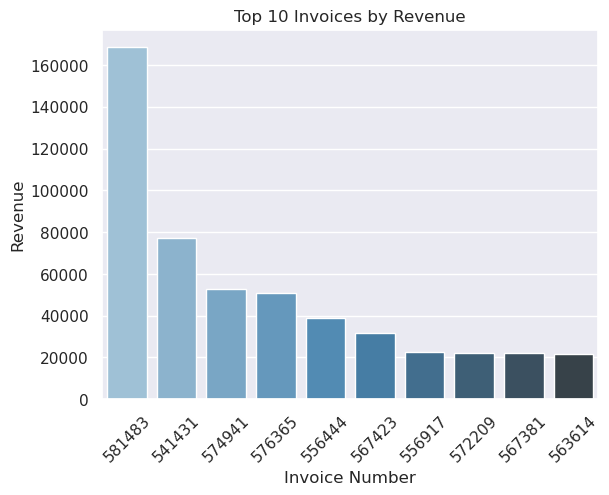

In [52]:
sns.barplot(x="InvoiceNo", y="InvoiceProfit", data=invoice_revenues.head(10), palette="Blues_d")

plt.title("Top 10 Invoices by Revenue")
plt.xlabel("Invoice Number")
plt.ylabel("Revenue")

plt.xticks(rotation=45)

plt.show()

### What is the total revenue for each customer?

In [53]:
query = """
with cte_test as
(
    select 
        cast(case
            when CustomerID = 0 then null else CustomerID
        end as int) as CustomerID,
        round(sum(Profit), 2) as CustomerProfit,
        count(*) as num_of_transactions
    from online_retail
    group by
        CustomerID
    order by sum(Profit) desc
)
select *
from cte_test
where
    CustomerID is not null;
"""

customer_revenues = SPARK.sql(query).toPandas()

customer_revenues.head()

,CustomerID,CustomerProfit,num_of_transactions
0,14646,271614.14,2006
1,18102,231822.69,413
2,17450,192361.95,333
3,16446,168472.50,3
4,14911,135973.23,5379


In [ ]:
# bar plot sorted by profit
sns.barplot(x="CustomerID", y="CustomerProfit", data=customer_revenues.head(10), palette="Blues_d")

plt.title("Top 10 Customers by Revenue")

plt.xlabel("Customer ID")

plt.ylabel("Revenue")

plt.xticks(rotation = 45)
plt.show()

### Revenue Trend

In [ ]:
new_df = df.copy()

new_df["InvoiceDate"] = new_df["InvoiceDate"].dt.date

new_df.sort_values(by="InvoiceDate", inplace=True)

new_df["Running_Sum"] = new_df["Profit"].cumsum()

new_df["Running_Sum"] = new_df["Running_Sum"].astype("float64")

new_df = new_df[['InvoiceDate', 'Profit', 'Running_Sum']]

In [ ]:
new_df.head()

In [ ]:
# line plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=new_df.InvoiceDate, y=new_df.Running_Sum,
                         
                            mode='lines',
                            name='lines'))

fig.update_layout(title='Cumulative Revenue',
                     xaxis_title='Date',
                        yaxis_title='Revenue')

fig.show()

## Product Analysis:
        Which products are the best-sellers in terms of quantity sold?
        What is the average unit price for each product?
        What is the distribution of products across different categories?
        Are there any products that are frequently bought together?

### Product Quantities

In [ ]:
query = """
select 
    StockCode,
    description,
    count(StockCode) as products_sold
from online_retail
group by 
    StockCode,
    description
order by count(StockCode) desc
limit 10
"""

top10_most_sold_products = SPARK.sql(query)

top10_most_sold_products.show()

In [ ]:
top10_most_sold_products = top10_most_sold_products.toPandas()

In [ ]:

sns.barplot(data = top10_most_sold_products, x = "products_sold", y = "StockCode", palette ='Blues_r')

plt.title("Top 10 Products by Count")
plt.show()

### Average unit of price

In [ ]:
print(f"Average Pirce of a Unit: {round(np.average(df.UnitPrice), 2)}")

### Products by Category

In [ ]:
descriptions = df.description
descriptions = descriptions.str.split().to_list()

In [ ]:
# product types
clothing_types = [
    "t-shirt",
    "jeans",
    "dress",
    "sweater",
    "shorts",
    "skirt",
    "jacket",
    "hoodie",
    "blouse",
    "suit",
    "pants",
    "coat",
    "shirt",
    "tank top",
    "leggings",
    "sweatshirt",
    "trousers",
    "blazer",
    "polo shirt",
    "jumpsuit",
]

# electronic types
electronic_types = [
    "smartphone",
    "laptop",
    "tablet",
    "television",
    "headphones",
    "smartwatch",
    "camera",
    "speaker",
    "gaming console",
    "router",
    "monitor",
    "keyboard",
    "mouse",
    "printer",
    "earbuds",
    "fitness tracker",
    "drone",
    "projector",
    "external hard drive",
    "bluetooth earphones",
]

food_types = [
    "pizza",
    "burger",
    "pasta",
    "sushi",
    "salad",
    "taco",
    "sandwich",
    "ramen",
    "steak",
    "ice cream",
    "chocolate",
    "cake",
    "coffee",
    "smoothie",
    "sushi",
    "doughnut",
    "burrito",
    "pancake",
    "croissant",
    "noodles",
    "candy"
]

In [ ]:
descriptions_categories = {}

for row in descriptions:
    for word in row:
        word = word.lower()
        if word in clothing_types:
            descriptions_categories[tuple(row)] = "Clothes"
            break
        
        elif word in electronic_types:
            descriptions_categories[tuple(row)] = "Eletronics"
            break 
        
        elif word in food_types:
            descriptions_categories[tuple(row)] = "Food"
            break 

        else:
            descriptions_categories[tuple(row)] = "Unidentified"

In [ ]:
new_df = df[["StockCode", "description"]]
new_df.head()

In [ ]:
categories = []
    
for row in new_df.iterrows():
    categories.append(descriptions_categories[tuple(row[1].description.split())])

new_df["Category"] = categories

new_df.head()

In [ ]:
new_df = SPARK.createDataFrame(new_df)

In [ ]:
new_df.createOrReplaceTempView("categories")

In [ ]:
query = """
select 
    category,
    count(*) as num_of_products
from categories
where
    category != 'Unidentified'
group by
    category
order by 
    count(*) desc
"""

new_df = SPARK.sql(query)

new_df.show()

##     Customer Analysis:
        Who are the top customers based on total spending?
        What is the distribution of customers by country?
        What is the average order quantity per customer?
        How often do customers make repeat purchases?

In [ ]:
df = load_data()
df = pre_processing(df)

spark_df = SPARK.createDataFrame(df).repartition(5)

In [ ]:
spark_df = SPARK.createDataFrame(df)

spark_df.createOrReplaceTempView("online_retail")

### Who are the top customers based on total spending?

In [ ]:
query = """
select 
    CustomerID,    
    round(sum(Profit), 2) as Total_Profit
from online_retail
where
    CustomerID != 0
group by
    CustomerID
order by
    round(sum(Profit), 2) desc
limit 10
"""

top10_customers = SPARK.sql(query).toPandas()

top10_customers.head()

In [ ]:
sns.barplot(data = top10_customers, x = "CustomerID", y = "Total_Profit", palette ='Blues_r', order = top10_customers.sort_values("Total_Profit", ascending = False).CustomerID)

plt.title("Top 10 Customers by Profit")
plt.ylabel("Profit")
plt.xticks(rotation = 45)

plt.show()

### What is the distribution of customers by country?


In [ ]:
query = """
select 
    country,    
    count(country) as country_count
from online_retail
group by
    country
order by
    count(country) desc
limit 10
"""

top10_countries = SPARK.sql(query).toPandas()

top10_countries.head()

In [ ]:
sns.catplot(data = top10_countries, x = "country_count", y = "country", palette ='Blues_r', kind = "bar")

plt.title("Top 10 Countries by Count")
plt.ylabel("Country")
plt.xticks(rotation = 45)

plt.subplots_adjust(left = 0, right = 1)

plt.show()


### What is the average order quantity per customer?

In [ ]:
print(f"Average Quantity per Order: {round(np.average(df.quantity), 2)}")

### How often do customers make repeat purchases?

In [ ]:
df = load_data()
df = pre_processing(df)

spark_df = SPARK.createDataFrame(df)

spark_df.createOrReplaceTempView("online_retail")

In [ ]:
query = """
with cte_temp as
(

    select 
        CustomerID,
        round(avg(diff), 2) as avg_days_between_purchase,
        count(CustomerID) as transaction_amount
    from
    (
        select 
            CustomerID,
            date_diff(InvoiceDate, lag1) as diff
        from
        (
            select 
                cast(CustomerID as integer) as CustomerID,
                InvoiceDate,
                lag(InvoiceDate, 1) over (partition by CustomerID order by InvoiceDate) as lag1
            from
            (
                select 
                    CustomerID,
                    InvoiceDate
                from online_retail
                where
                    CustomerID != 0
                group by
                    CustomerID,
                    InvoiceDate
                order by
                    CustomerID desc, InvoiceDate desc
            )
        ) 
    ) 
    group by CustomerID
)

select *
from cte_temp
where avg_days_between_purchase > 0
order by avg_days_between_purchase
"""

most_frequent_customers = SPARK.sql(query)

most_frequent_customers.show()


In [ ]:
most_frequent_customers = most_frequent_customers.toPandas()

In [ ]:
most_frequent_customers = most_frequent_customers[(most_frequent_customers["avg_days_between_purchase"] < 50) & (most_frequent_customers["transaction_amount"] >= 5)].sort_values("CustomerID")

sns.relplot(data = most_frequent_customers, 
            y = "avg_days_between_purchase", 
            x = "transaction_amount", palette ='Reds', 
            kind = "scatter", hue = "transaction_amount", size = "transaction_amount", sizes = (10, 250), alpha = 0.8)

# Annotate most frequent customers
plt.annotate("Dead Zone", xy=[10,50])

plt.annotate("Whales", xy=[125,5])

plt.title("Most Frequent Customers")

plt.xlabel("Number of Transactions")

plt.ylabel("Average Days Between Purchase")

plt.show()

In [ ]:
print(f"The average number of days it takes a customer to buy another product is: {round(np.average(most_frequent_customers.avg_days_between_purchase), 2)}")

##    Time Analysis:
        What are the busiest months in terms of sales volume?
        Is there a pattern in sales based on days of the week?
        How does sales performance vary by different times of the day?

In [ ]:
df = load_data()
df = pre_processing(df)

spark_df = SPARK.createDataFrame(df)
spark_df.createOrReplaceTempView("online_retail")

### What are the busiest months in terms of sales volume?

In [ ]:
query = """
select 
    month(InvoiceDate) as month,
    round(sum(profit), 2) as Total_Profit,
    count(*) as num_of_transactions
from online_retail
group by
    month(InvoiceDate)
order by
    month(InvoiceDate)
"""

profits_per_month = SPARK.sql(query)

profits_per_month.show()

In [ ]:
profits_per_month = profits_per_month.toPandas()

In [ ]:
profits_per_month.to_csv("profits_per_month.csv")

In [ ]:
sns.barplot(data = profits_per_month, x = "month", y = "Total_Profit", hue="month", palette="Blues_r", order = profits_per_month.sort_values("Total_Profit", ascending = False).month , legend=False)
sns.barplot(data = profits_per_month, x = "month", y = "num_of_transactions", hue="month", palette="Reds", order = profits_per_month.sort_values("num_of_transactions", ascending = False).month, legend=False)

plt.title("Total Profit + num of transactions per Month")

plt.xlabel("Month")

plt.ylabel("Total Profit")

plt.show()

### Is there a pattern in sales based on days of the week?

In [ ]:
query = """
select 
    cast(InvoiceDate as date) as InvoiceDate,
    round(sum(profit), 2) as daily_profit
from online_retail
group by
    cast(InvoiceDate as date)
order by
    InvoiceDate
"""

profits_per_day = SPARK.sql(query)

profits_per_day.show()

In [ ]:
profits_per_day = profits_per_day.toPandas()

In [ ]:
profits_per_day.to_csv("profits_per_day.csv")

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=profits_per_day.InvoiceDate, y=profits_per_day.daily_profit,
                         
                            mode='lines',
                            name='lines'))

fig.update_layout(title='Daily Revenue',

                        xaxis_title='Date',
                        yaxis_title='Revenue')

fig.show()

In [ ]:
query = """
select 
    cast(InvoiceDate as date) as InvoiceDate,
    day(cast(InvoiceDate as date)) as day,
    month(cast(InvoiceDate as date)) as month,
    round(sum(profit), 2) as daily_profit,
    count(*) as num_of_transactions
from online_retail
group by
    cast(InvoiceDate as date),
    day(cast(InvoiceDate as date)),
    month(cast(InvoiceDate as date))
order by
    InvoiceDate
"""

revenue_density = SPARK.sql(query)

revenue_density.show()

In [ ]:
revenue_density = revenue_density.toPandas()

In [ ]:
revenue_density.to_csv("revenue_density.csv")

In [ ]:
sns.kdeplot(data = revenue_density, x = "daily_profit", fill = True, alpha = 0.5)

plt.title("Daily Revenue Distribution")

plt.xlabel("Daily Revenue")

plt.ylabel("Density")

plt.show()

In [ ]:
sns.kdeplot(data = revenue_density, x = "num_of_transactions", fill = True, alpha = 0.5)

plt.title("Daily Transactions Distribution")

plt.xlabel("Daily Transactions")

plt.ylabel("Density")

plt.show()